In [63]:
import time
import functools
# JAX library : une nouvelle venue dans le domaine 
#       l'auto-differentiation
#       la compilation Just-In-Time 
#       l'optilisation XLA du code compile pour le device CPU/GPU/TPU

import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

from jax.config import config
config.update("jax_enable_x64", True)


# Numpy 
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
#plt.style.use('seaborn-paper')
#mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
from matplotlib.patches import Ellipse

# Some mock data

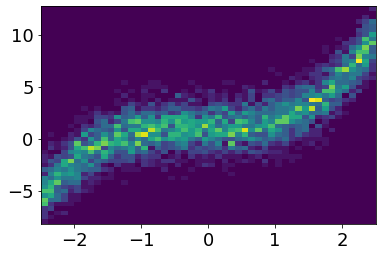

In [2]:
param_true = np.array([1.0, 0.0, 0.2, 0.5])
sample_size = 5_000
sigma_e = 1.5         # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
xi = 5*random_num_generator.rand(sample_size)-2.5
e = random_num_generator.normal(0, sigma_e, sample_size)
yi = param_true[0] + param_true[1] * xi + param_true[2] * xi**2 + param_true[3] *xi**3 +  e  
plt.hist2d(xi, yi, bins=50);

In [3]:
def mu(params, Xspls):
    a0,a1,a2,a3 = params
    return a0 + a1*Xspls + a2*Xspls**2 + a3*Xspls**3

In [4]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p, Xspls=xi).flatten()))


In [5]:
j = jacobian(param_true)

In [6]:
Cov_inv = jnp.eye(xi.shape[0])/sigma_e**2

In [7]:
Fisher =  jnp.einsum('ia,ij,jb',j,Cov_inv,j)

In [8]:
Fisher.shape

(4, 4)

In [160]:
def plot_contours(fisher, pos, inds=[1,0], nstd=1., ax=None, setxy=True, **kwargs):
    """
      Plot 2D parameter contours given a Hessian matrix of the likelihood
      # inds=[i,j] i: x-axis, j: y-axis
    """
    i,j = inds
  
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    mat = fisher
    cov = np.linalg.inv(mat)
    sigma_marg = lambda i: np.sqrt(cov[i, i])

    if ax is None:
        ax = plt.gca()

    # Extracts the block we are interested in
    block_cov = cov[:,[i,j]][[i,j],:]
    vals, vecs = eigsorted(block_cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos[[i,j]], width=width,
                       height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    
    if setxy:
        sz = max(width, height)
        s1 = 1.5*nstd*sigma_marg(i)
        s2 = 1.5*nstd*sigma_marg(j)
        ax.set_xlim(pos[i] - s1, pos[i] + s1)
        ax.set_ylim(pos[j] - s2, pos[j] + s2)
    
    ax.scatter(pos[i],pos[j],s=30,c="red")
    
#    plt.draw()
    return ellip

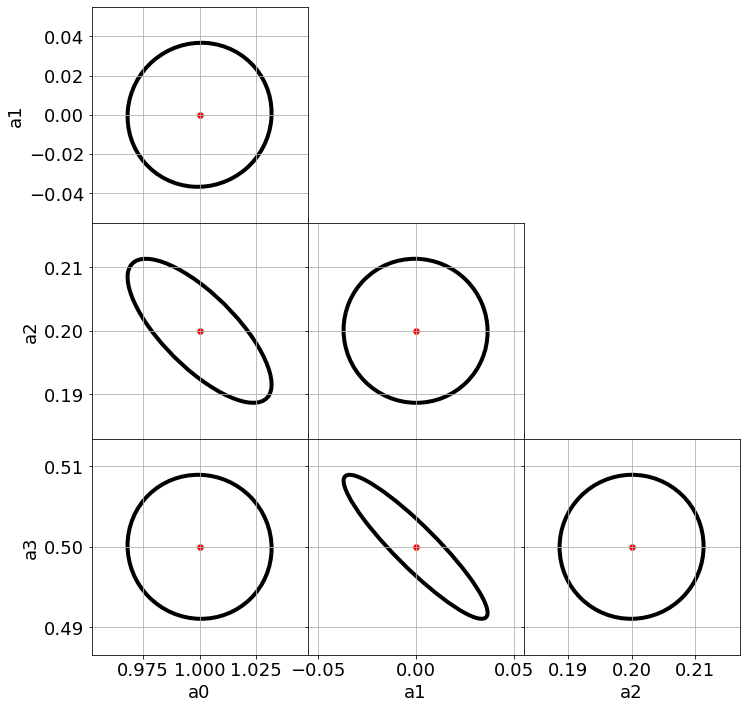

In [10]:
from matplotlib import gridspec

n = param_true.shape[0]
fig =plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(n-1, n-1, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.05, right=0.95) 

for i in range(1,n):
    for j in range(0,i):
        ax = plt.subplot(gs[i-1,j])
        plot_contours(Fisher, param_true, inds=[j,i], fill=False,color='black',lw=4, 
                      ax=ax)
        ax.grid()
        if j==0:
            ax.set_ylabel(f"a{i}")
        if i==n-1:
            ax.set_xlabel(f"a{j}")

for ax in fig.get_axes():
    ax.label_outer()

for i in range(n-1):
    for j in range(i+1,n-1):
        fig.delaxes(plt.subplot(gs[i,j]))


# Usage d'un code de generation de chaines de Markov et comparaison des contours avec Fisher

In [104]:
import numpyro
from numpyro.infer import MCMC, HMC, NUTS, init_to_sample, init_to_value
import numpyro.distributions as dist

In [15]:
def my_model(Xspls,Yspls=None):
    a0 = numpyro.sample('a0', dist.Normal(0.,10.))
    a1 = numpyro.sample('a1', dist.Normal(0.,10.))
    a2 = numpyro.sample('a2', dist.Normal(0.,10.))
    a3 = numpyro.sample('a3', dist.Normal(0.,10.))

    params = (a0,a1,a2,a3)
    mu_val =  mu(params, Xspls)

    return numpyro.sample('obs', dist.Normal(mu_val, sigma_e), obs=Yspls)

In [111]:
d_true = {}
for i,p in enumerate(param_true):
    d_true["a"+str(i)]=np.array(param_true[i])

In [190]:
rng_key = jax.random.PRNGKey(0)
_, rng_key, rng_key1, rng_key2 = jax.random.split(rng_key, 4)


# Run NUTS.
kernel = NUTS(my_model, 
             init_strategy=numpyro.infer.init_to_value(values=d_true),
            dense_mass=True)
num_samples = 10_000
n_chains = 1
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,progress_bar=True)
mcmc.run(rng_key, Xspls=xi, Yspls=yi)

mcmc.print_summary()
samples_nuts = mcmc.get_samples()

sample: 100%|██████████| 11000/11000 [00:25<00:00, 435.28it/s, 7 steps of size 7.08e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0      1.02      0.03      1.02      0.97      1.07   8560.65      1.00
        a1      0.03      0.04      0.03     -0.03      0.09   8755.81      1.00
        a2      0.18      0.01      0.18      0.17      0.20   9207.33      1.00
        a3      0.49      0.01      0.49      0.48      0.51   9458.74      1.00

Number of divergences: 0


In [191]:
samples_nuts['a0'].shape

(10000,)

In [192]:
import corner
import arviz as az
az.style.use("seaborn")

In [193]:
param_med = np.mean(np.array(list(samples_nuts.values())),axis=1)

In [194]:
param_med

array([1.01869829, 0.03156366, 0.18380848, 0.49139051])

In [195]:
param_true

array([1. , 0. , 0.2, 0.5])

## Comparaison des contours n-sigma obtenus en exploitant les échantillons MCMC et ceux obtenus avec la matrice de Fisher calculée au point median des échantillons.

In [196]:
j = jacobian(param_med)
Fisher_med =  jnp.einsum('ia,ij,jb',j,Cov_inv,j)

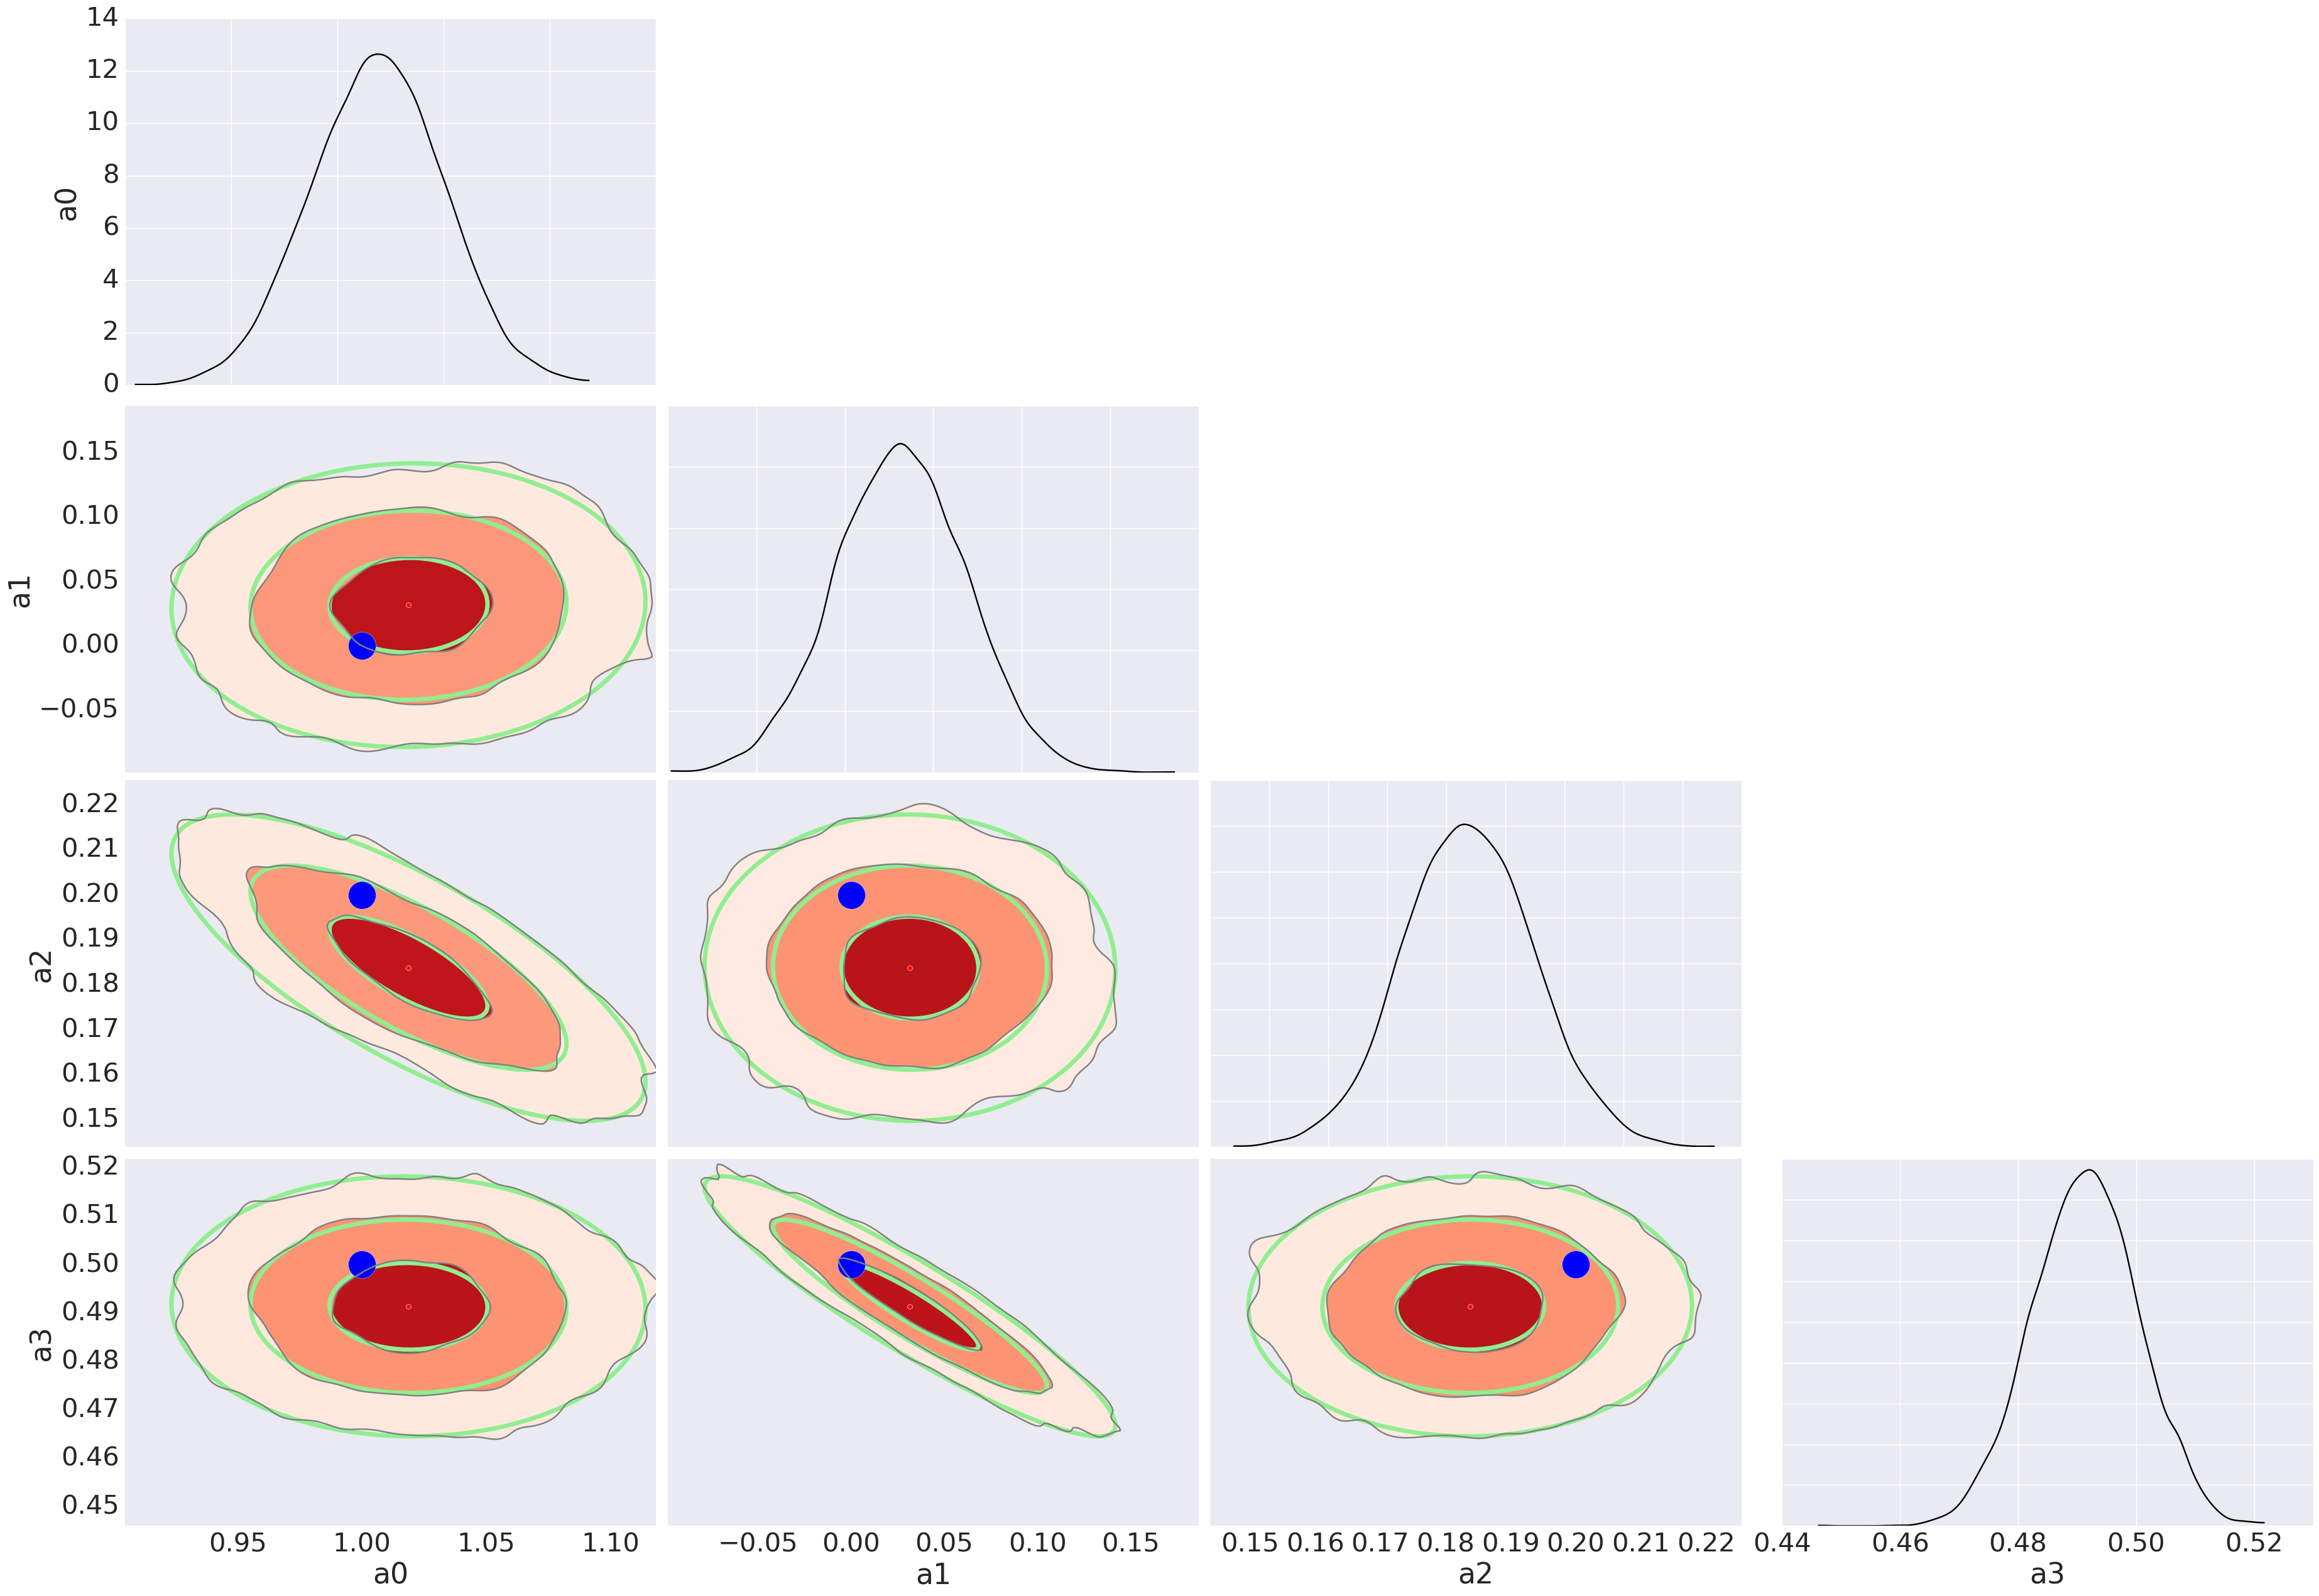

In [197]:
axs = az.plot_pair(
    samples_nuts,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.393, 0.865, 0.989],  # Plot 1sigma, 2sigma, 3sigma HDI contours
        "contourf_kwargs": {"cmap": "Reds"},
    },
    marginal_kwargs={"color": "Black"},
    marginals=True,
    textsize=30,
);
n = param_med.shape[0]
for i in range(1,n):
    for j in range(0,i):
        ax = axs[i,j]
        # 1sigma contour Fisher
        plot_contours(Fisher_med, param_med, inds=[j,i], fill=False,color='lightgreen',lw=5, setxy=False,
                      ax=ax, nstd=1)
        # 2sigma
        plot_contours(Fisher_med, param_med, inds=[j,i], fill=False,color='lightgreen',lw=5, setxy=False,
                      ax=ax, nstd=2)
        # 3sigma
        plot_contours(Fisher_med, param_med, inds=[j,i], fill=False,color='lightgreen',lw=5, setxy=False,
                      ax=ax, nstd=3)
        ax.scatter(param_true[j],param_true[i],s=1000,c='blue') # position corredspondant aux vrais parametres
